### Лабораторная работа № 3. Вариант №2. Горшков Артем Владимирович

#### 1. Найти цену американского call опциона

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

In [98]:
X = 400
Put = 9
S = 389
r = .01
T = 5

$$
Call - Put = S - X \cdot e^{-r * T}
\\
Call = S - X \cdot e^{-r * T} + Put
$$

In [99]:
Call = S - X * np.exp(-r * T) + Put

In [100]:
print(f'Цена Европейского call опциона - {Call:.2f}')

Цена Европейского call опциона - 17.51


In [101]:
print(f'Значит, цена американского call опциона также равна - {Call:.2f}')

Значит, цена американского call опциона также равна - 17.51


#### 2. Построение биномиальной модели

In [102]:
# Аналитическое решение для европейских опционов
def analytical_calculate_option_price(S, X, r, t, sigma, option_type):
    d1 = (np.log(S/X) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    if option_type == 'call':
        return S * norm.cdf(d1) - X * np.exp(-r * t) * norm.cdf(d2)
    elif option_type == 'put':
        return X * np.exp(-r * t) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [103]:
class Node:
    def __init__(self, data: float, left=None, right=None, period=None):
        self.data = data
        self.left = left
        self.right = right
        self.period = period
        self.p = None # Prob for left turn

    def __str__(self):
        return f'{self.data:.3f}'

class Model:

    def __init__(self, N: int, T: int, S: float, sigma: float, r: float):
        self.N = N + 1
        self.T = T
        self.sigma = sigma
        self.r = r
        self.root = Node(S, T, period=0)


        self._generate_layer(self.root, 1)

    def _generate_layer(self, curr_node: Node, step: int):
        if step == self.N:
            return None
        S = curr_node.data
        dt = self.T / self.N
        u = np.exp(self.sigma * np.sqrt(dt))
        d = np.exp(-self.sigma * np.sqrt(dt))


        curr_node.left = Node(S * u, period=step * (dt))
        curr_node.right = Node(S / u, period=step * (dt))
        self._generate_layer(curr_node.left, step + 1)
        self._generate_layer(curr_node.right, step + 1)

    def traverseInorder(self, root):
        result = []
        if root is not None:
            result.append(root)
            result.extend(self.traverseInorder(root.left))
            result.extend(self.traverseInorder(root.right))
        return result

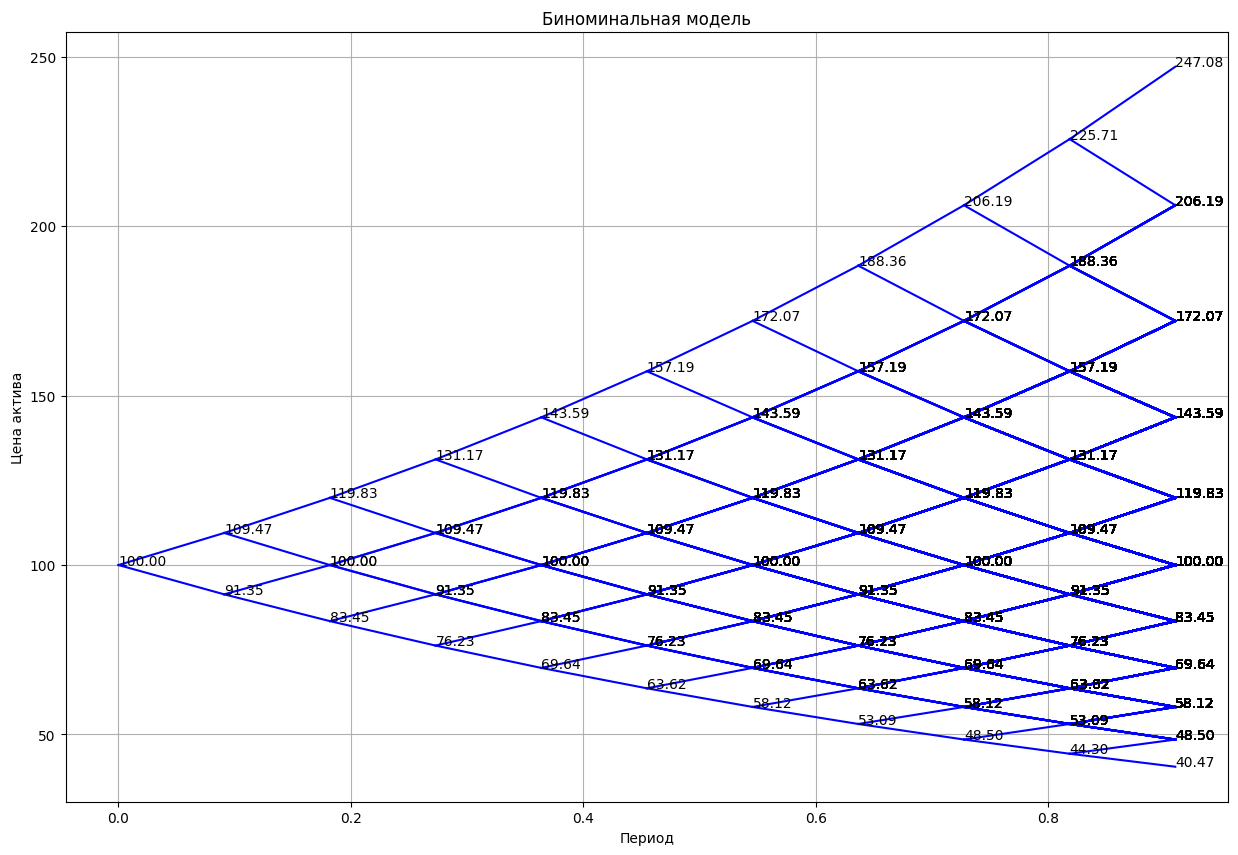

In [104]:
result = Model(10, 1, 100, 0.3, 0.08)
root = result.root

plt.figure(figsize=(15, 10))
plt.grid()
plt.title('Биноминальная модель')
plt.xlabel('Период')
plt.ylabel('Цена актива')
dot_x = []
dot_y = []
for node in result.traverseInorder(result.root):
    if node.left is not None:
        plt.plot((node.period, node.left.period),(node.data, node.left.data),  c='blue')
        plt.plot((node.period, node.right.period),(node.data, node.right.data),  c='blue')
        plt.text(node.period, node.data, f'{node.data:.2f}')
    else:
        plt.text(node.period, node.data, f'{node.data:.2f}')

In [105]:
# Формулы для расчета u, d, p
u_f = lambda sigma, dt: np.exp(sigma * np.sqrt(dt))
d_f = lambda sigma, dt: np.exp(-sigma * np.sqrt(dt))
p_f = lambda sigma, r, dt: (np.exp(r * dt) - d_f(sigma, dt)) / (u_f(sigma, dt) - d_f(sigma, dt))

def calculate_option_price(s, X, sigma, T, r, N, t='call', c_t='eu'):
    dt = T / N
    u = u_f(sigma, dt)
    d = d_f(sigma, dt)
    p = p_f(sigma, r, dt)

    # Находим S (цену актива) на последнем слое
    i = N
    S = [s * (u ** j) * (d ** (i - j))
         for j in range(N + 1)]

    # Находим цену опциона в дату исполнения (последний слой)
    if t == 'call':
        V = [max(0, S[j] - X) for j in range(N + 1)]
    else:
        V = [max(0, X - S[j]) for j in range(N + 1)]

    # Находим цену опциона в остальные моменты времени (Обратный проход по дереву)
    if c_t == 'eu':
        for i in range(N, 0, -1):
            for j in range(i):
                V[j] = np.exp(-r * dt) * (p * V[j + 1] + (1 - p) * V[j])
    else:
        # Если опцион американский, справедливую цену считаем как масимум внутренней и ожидаемой цен
        for i in range(N - 1, -1, -1):
            for j in range(i + 1):
                S =  s * u ** j * d ** (i - j)
                if t == 'call':
                    V[j] = max(np.exp(-r * dt) * (p * V[j + 1] + (1 - p) * V[j]), S - X)
                else:
                    V[j] = max(np.exp(-r * dt) * (p * V[j + 1] + (1 - p) * V[j]), X - S)

    return V[0]

In [106]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Метод для итераций
def iterative_calculate_option_price(S, X, sigma, T, r, t, c_t, N1, N2):
    prices = []
    with ThreadPoolExecutor(max_workers=13) as executor:
        futures = []
        for N in range(N1, N2 + 1):
            futures.append(executor.submit(calculate_option_price, S, X, sigma, T, r, N, t, c_t))

        for future in tqdm(as_completed(futures), total=len(futures)):
            prices.append(future.result())
        return prices

In [107]:
# Метод для построения графика
def iteration_plot(result, t, c_t, N):
    plt.figure(figsize=(15, 10))
    plt.title(f'Зависимость цены опциона от количества итераций ({c_t})/{t}')
    even_x, even_y = [], []
    odd_x, odd_y = [], []
    for i in range(N[0], N[1] + 1):
        if i % 2 == 0:
            even_x.append(i)
            even_y.append(result[i - N[0]])
        else:
            odd_x.append(i)
            odd_y.append(result[i - N[0]])

    plt.scatter(even_x, even_y, color='blue', label='Цена опциона')
    plt.scatter(odd_x, odd_y, color='red', label='Цена опциона')
    # plt.scatter(list(range(N[0], N[1] + 1)), result, label='Цена опциона')
    plt.xlabel('Итерация')
    plt.ylabel('Цена опциона')
    plt.grid()
    plt.show()

In [108]:
S = 100
X = 100
T = 1
r = 0.08
sigma = 0.3
N = (20, 400)

## EU, Call

In [109]:
call_eu_result = iterative_calculate_option_price(S, X, sigma, T, r, 'call', 'eu', N[0], N[1])

100%|██████████| 381/381 [00:14<00:00, 26.97it/s]  


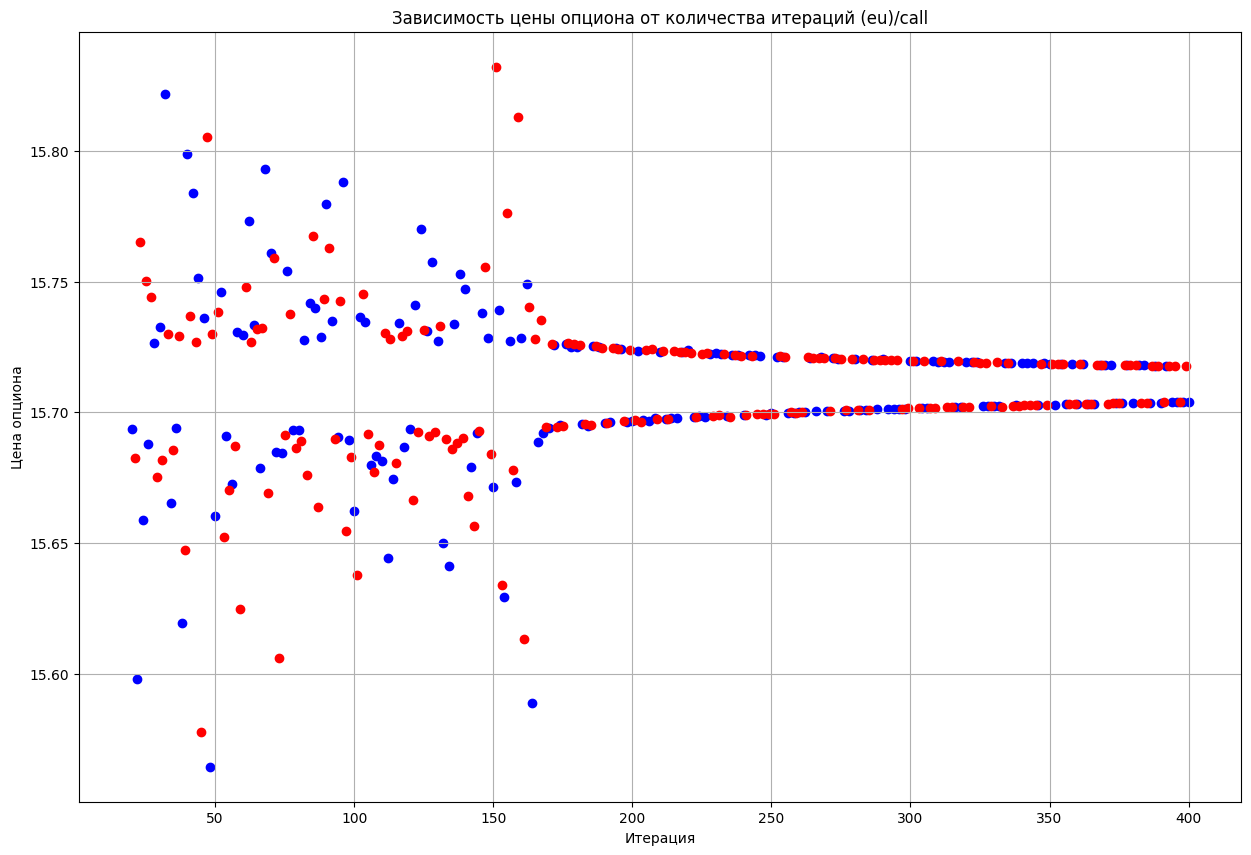

In [111]:
iteration_plot(call_eu_result, 'call', 'eu', N)

In [112]:
print(f'Цена по формуле Блека-Шоулза - {analytical_calculate_option_price(S, X, r, T, sigma, "call"):.3f}')
print(f'Цена по биноминальной модели на 400 итерации - {call_eu_result[-1]:.3f}')

Цена по формуле Блека-Шоулза - 15.711
Цена по биноминальной модели на 400 итерации - 15.704


## EU, Put

In [113]:
put_eu_result = iterative_calculate_option_price(S, X, sigma, T, r, 'put', 'eu', N[0], N[1])


100%|██████████| 381/381 [00:14<00:00, 27.06it/s]  


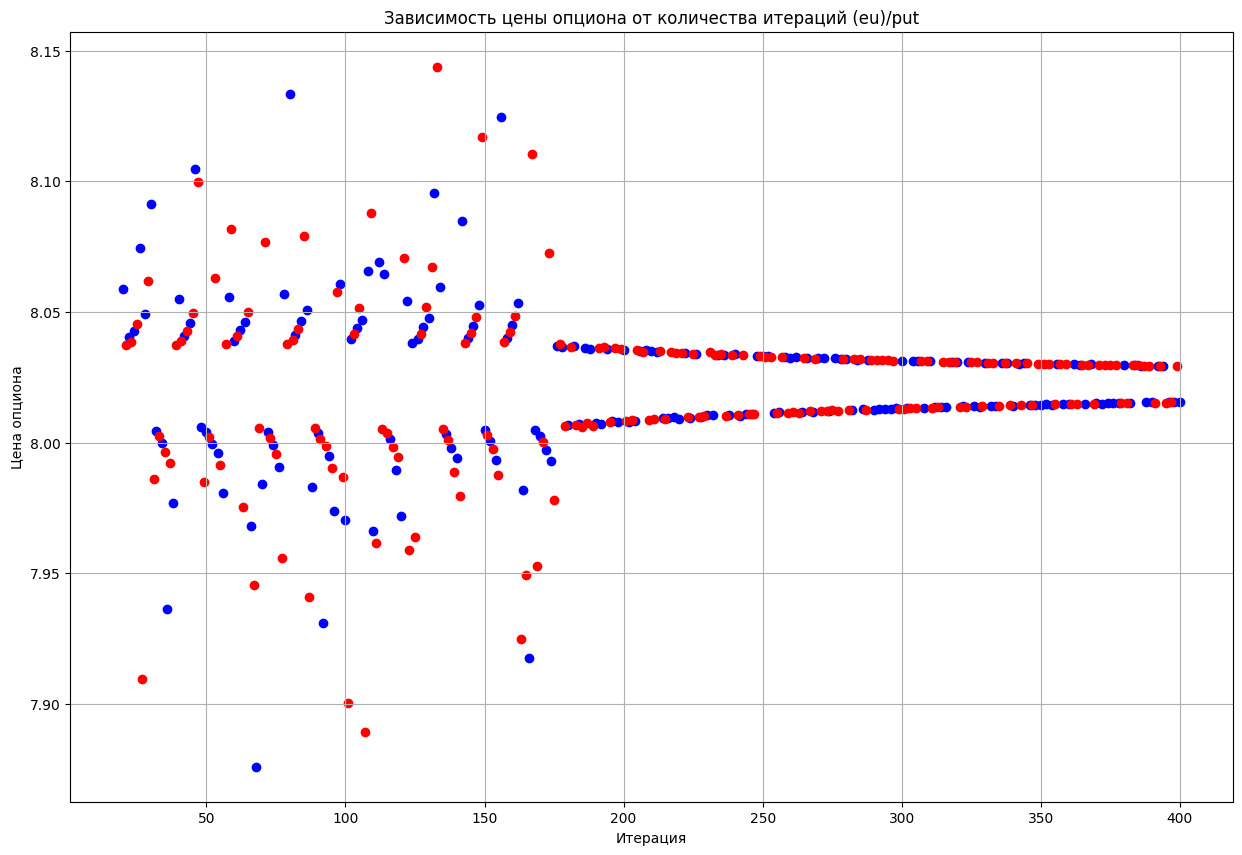

In [114]:
iteration_plot(put_eu_result, 'put', 'eu', N)

In [115]:
print(f'Цена по формуле Блека-Шоулза - {analytical_calculate_option_price(S, X, r, T, sigma, "put"):.3f}')
print(f'Цена по биноминальной модели на 400 итерации - {put_eu_result[-1]:.3f}')

Цена по формуле Блека-Шоулза - 8.023
Цена по биноминальной модели на 400 итерации - 8.016


## American, Call

In [116]:
call_am_result = iterative_calculate_option_price(S, X, sigma, T, r, 'call', 'am', N[0], N[1])

100%|██████████| 381/381 [00:22<00:00, 16.83it/s] 


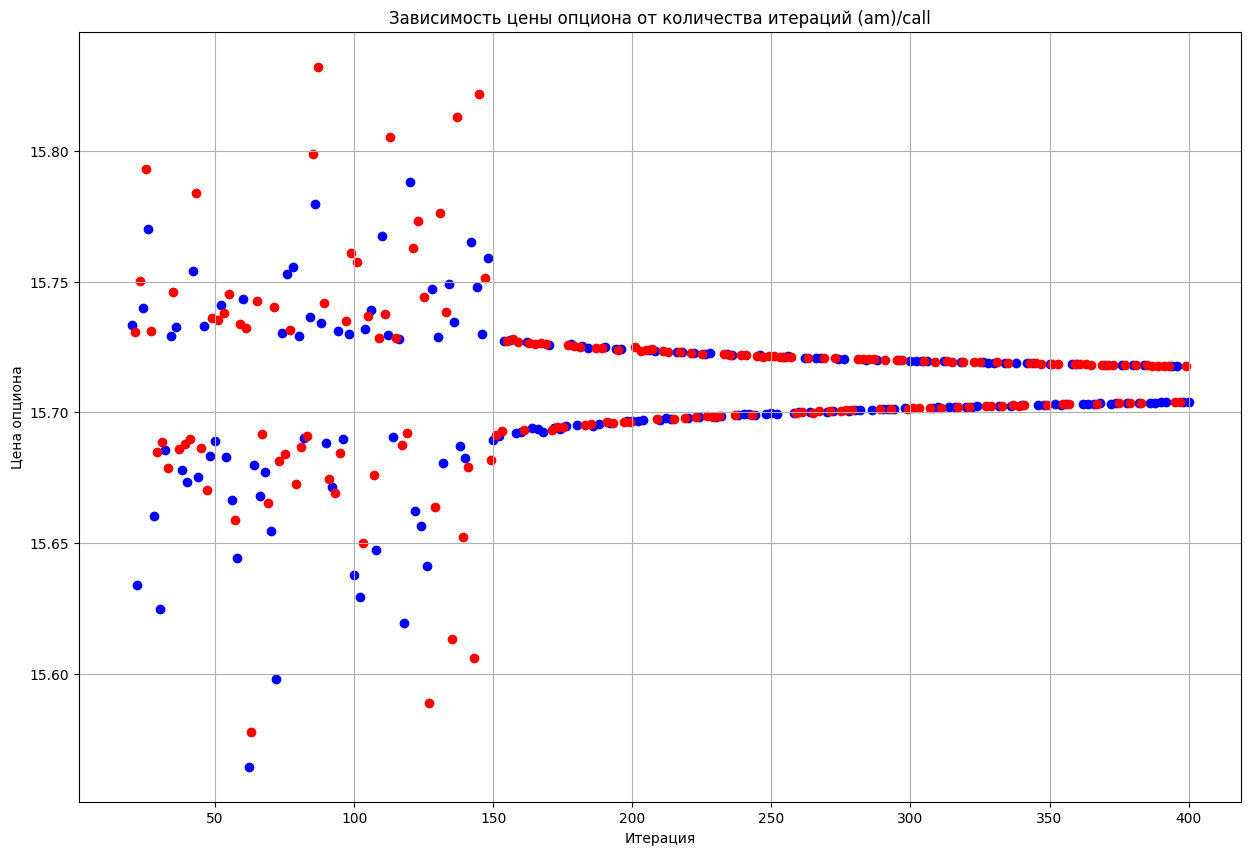

In [117]:
iteration_plot(call_am_result, 'call', 'am', N)

In [118]:
from optionprice import Option
some_option = Option(european=False,
                    kind='call',
                    s0=100,
                    k=100,
                    t=365,
                    sigma=0.3,
                    r=0.08,
                    dv=0)
#put_price = some_option.getPrice(method='BT',iteration = 2000)
call_price = 15.709833167202854
print(call_price)

15.709833167202854


In [119]:
print(f'Цена по option-price - {call_price}')
print(f'Цена по биноминальной модели на 400 итерации - {call_am_result[-1]:.3f}')

Цена по option-price - 15.709833167202854
Цена по биноминальной модели на 400 итерации - 15.704


## American, Put

In [120]:
put_am_result = iterative_calculate_option_price(S, X, sigma, T, r, 'put', 'am', N[0], N[1])

100%|██████████| 381/381 [00:23<00:00, 16.04it/s] 


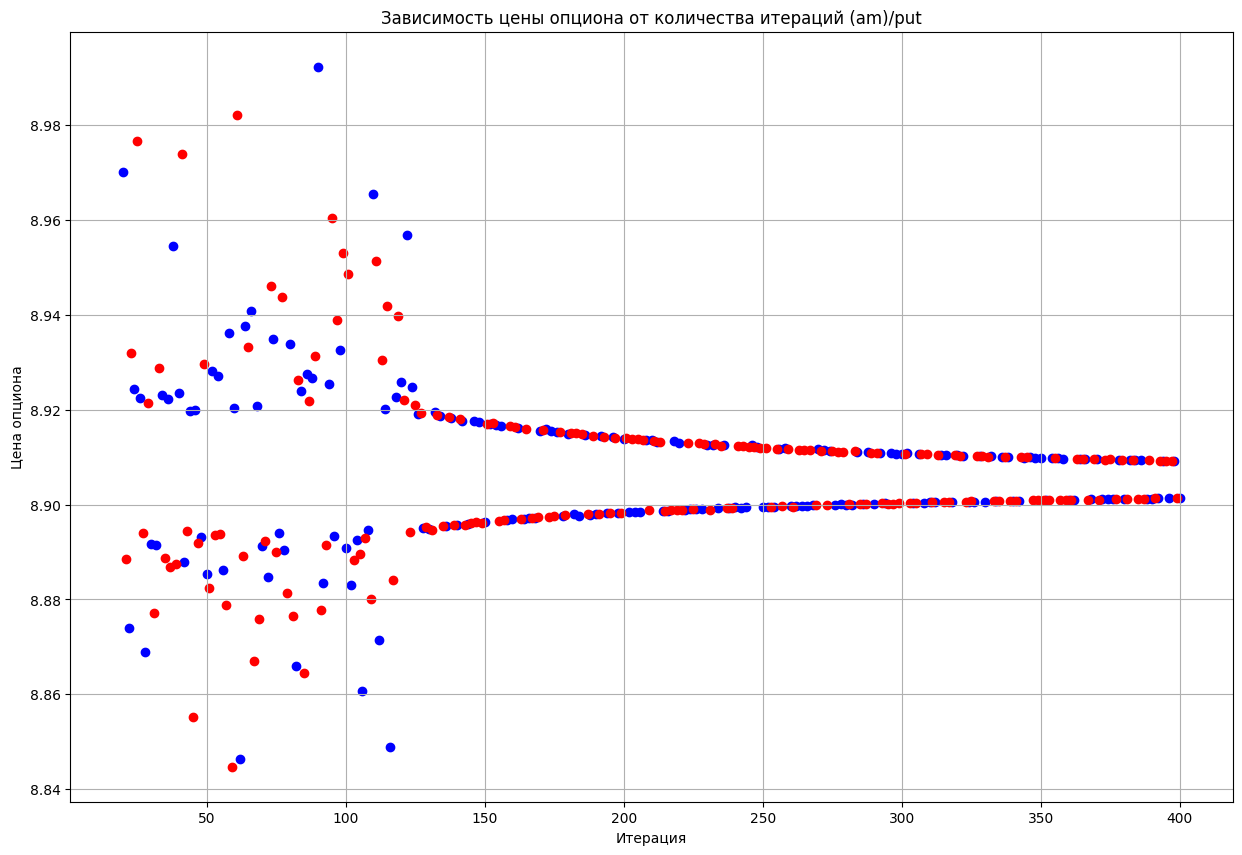

In [121]:
iteration_plot(put_am_result, 'put', 'am', N)

In [122]:
from optionprice import Option
some_option = Option(european=False,
                    kind='put',
                    s0=100,
                    k=100,
                    t=365,
                    sigma=0.3,
                    r=0.08,
                    dv=0)
#put_price = some_option.getPrice(method='BT',iteration = 2000)
put_price = 8.903680465129112
print(put_price)

8.903680465129112


In [123]:
print(f'Цена по option-price - {put_price}')
print(f'Цена по биноминальной модели на 400 итерации - {put_am_result[-1]:.3f}')

Цена по option-price - 8.903680465129112
Цена по биноминальной модели на 400 итерации - 8.901


In [124]:
print(f'Call EU по формуле - {analytical_calculate_option_price(S, X, r, T, sigma, "call"):.3f}')
print(f'Call EU по бином - {call_eu_result[-1]:.3f}')
print(f'Put EU по формуле - {analytical_calculate_option_price(S, X, r, T, sigma, "put"):.3f}')
print(f'Put EU по бином - {put_eu_result[-1]:.3f}')
print(f'Call AM по option-price - {call_price}')
print(f'Call AM по бином - {call_am_result[-1]:.3f}')
print(f'Put AM по option-price - {put_price}')
print(f'Put AM по бином - {put_am_result[-1]:.3f}')

Call EU по формуле - 15.711
Call EU по бином - 15.704
Put EU по формуле - 8.023
Put EU по бином - 8.016
Call AM по option-price - 15.709833167202854
Call AM по бином - 15.704
Put AM по option-price - 8.903680465129112
Put AM по бином - 8.901


## Поменяйте страйк на X=93

In [127]:
S = 100
X = 93
T = 1
r = 0.08
sigma = 0.3
N = (20, 400)

In [128]:
new_call_eu_result = iterative_calculate_option_price(S, X, sigma, T, r, 'call', 'eu', N[0], N[1])

100%|██████████| 381/381 [00:13<00:00, 29.25it/s]  


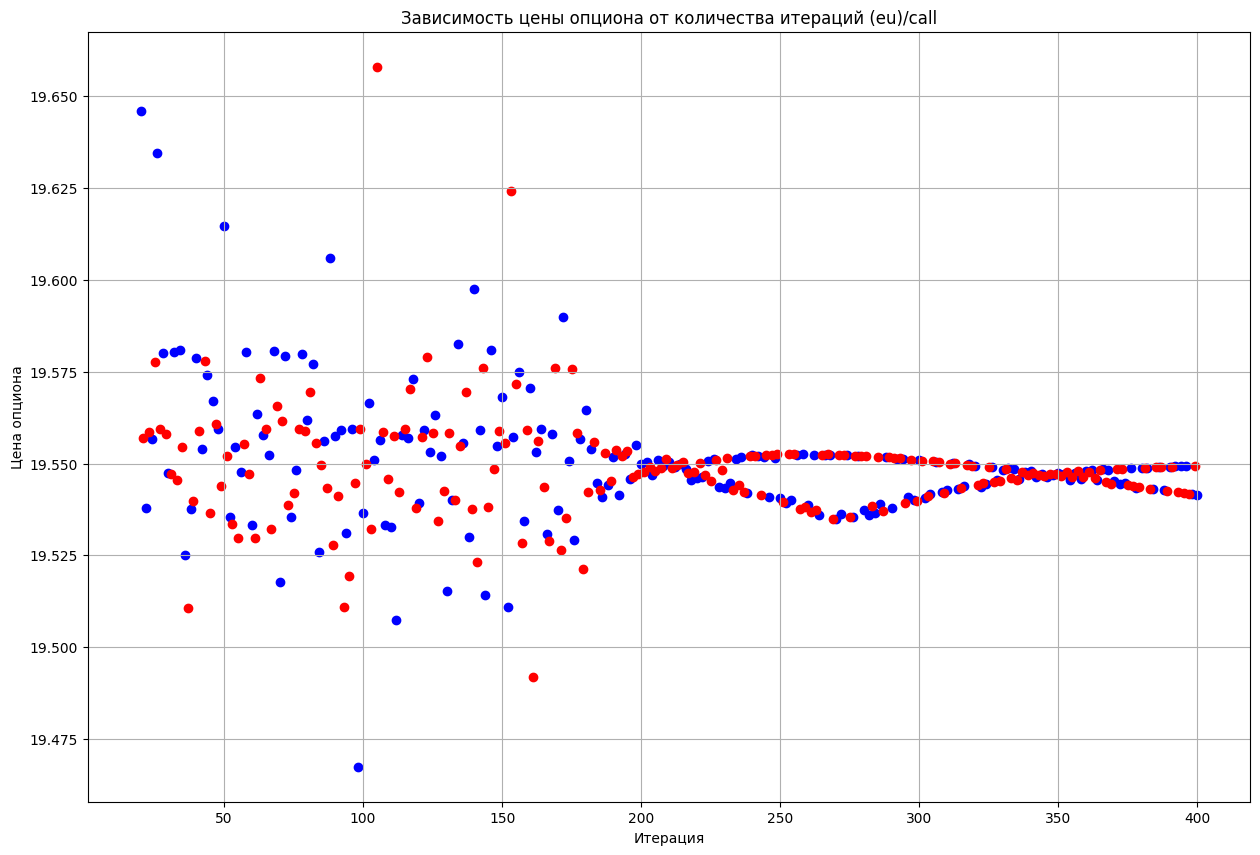

In [129]:
iteration_plot(new_call_eu_result, 'call', 'eu', N)